In [1]:
import idx2numpy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [2]:
train_images_path = '../../../Documents/data/MNIST_ORG//train-images.idx3-ubyte'
train_labels_path = '../../../Documents/data/MNIST_ORG//train-labels.idx1-ubyte'
test_images_path = '../../../Documents/data/MNIST_ORG//t10k-images.idx3-ubyte'
test_labels_path = '../../../Documents/data/MNIST_ORG//t10k-labels.idx1-ubyte'

# 📸 **A Picture is Worth 100 Convolutions** 🧩

Welcome to this exciting exploration of convolutions, particularly focusing on how to code them in PyTorch! 🎨🔍 Convolutions are a fundamental building block in deep learning, lesson05 gives you a better feel as to convolitions but here we jsut explore coding one up.

Let's get started and uncover the power of convolutions! 🚀📚


In [3]:
#laod data
X_train = idx2numpy.convert_from_file(train_images_path)
y_train = idx2numpy.convert_from_file(train_labels_path)
X_test = idx2numpy.convert_from_file(test_images_path)
y_test = idx2numpy.convert_from_file(test_labels_path)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


### 📊 Let's Look at What One Looks Like

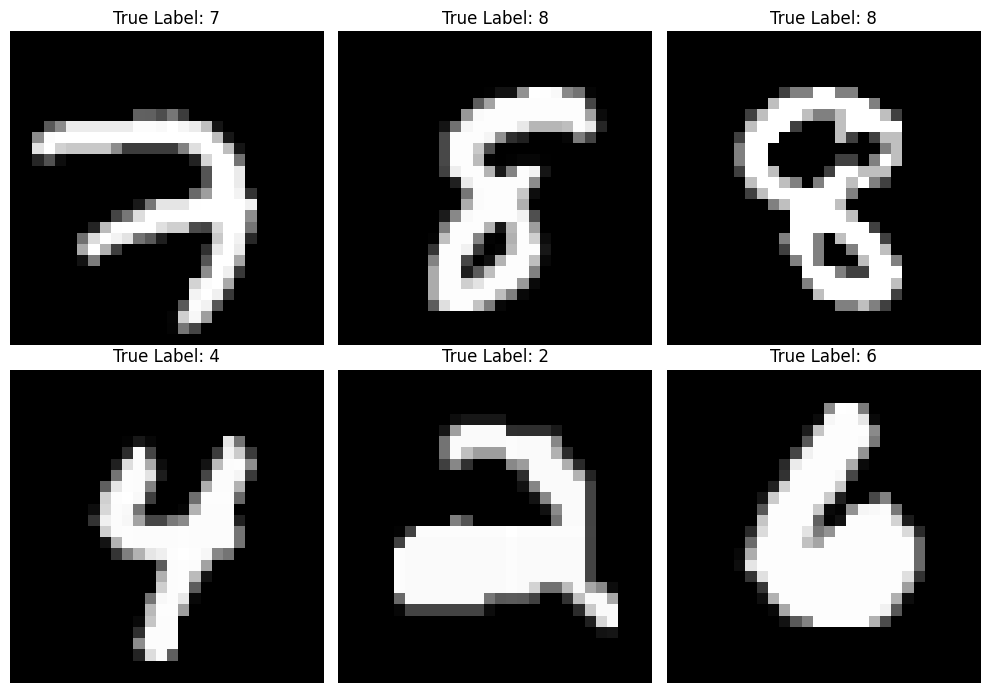

In [4]:
indices = [5000, 2001, 2002, 2003, 2004, 2005]

fig, axes = plt.subplots(2, 3, figsize=(10, 7))

for ax, idx in zip(axes.flatten(), indices):
    ax.imshow(X_train[idx], cmap='gray')
    ax.set_title(f'True Label: {y_train[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### 📈 Distribution of Each Class

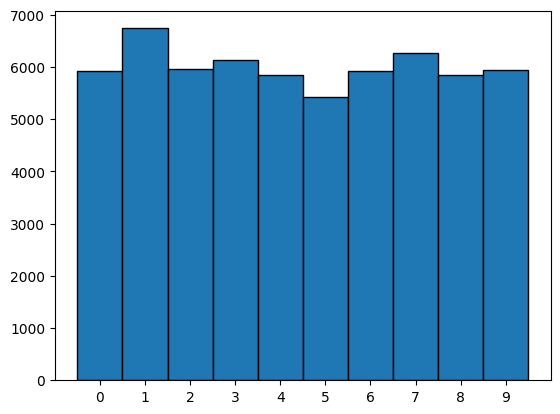

In [12]:
plt.hist(y_train, bins=np.arange(11)-.5, edgecolor='black');
plt.xticks([i for i in range(10)]);

In [13]:
unique, counts =np.unique(y_train, return_counts=True)
count_dic = dict(zip(unique, counts))


print(f'The max class is {max(count_dic, key=count_dic.get)} and min class is {min(count_dic, key=count_dic.get)}.')
print(f'Class {max(count_dic, key=count_dic.get)} has {(max(count_dic.values())-min(count_dic.values()))/min(count_dic.values())*100:.1f}% more values than class {min(count_dic, key=count_dic.get)}')

The max class is 1 and min class is 5.
Class 1 has 24.4% more values than class 5



So, our dataset is pretty balanced, and we will go ahead and start with some MLP. 🚀


In [14]:
X_train.shape

(60000, 28, 28)

In [4]:
X_train = torch.Tensor(X_train).flatten(start_dim=1 , end_dim=2)
y_train = torch.Tensor(y_train).long()
#they are no one hot encoded but rather [4,6,8,......]
y_train = nn.functional.one_hot(y_train,num_classes=10).float()

X_test = torch.Tensor(X_test).flatten(start_dim=1 , end_dim=2)
y_test = torch.Tensor(y_test).long()
y_test = nn.functional.one_hot(y_test,num_classes=10).float()

/tmp/ipykernel_5011/903889106.py:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  X_train = torch.Tensor(X_train).flatten(start_dim=1 , end_dim=2)


In [16]:
X_train.shape

torch.Size([60000, 784])

In [17]:
y_train.argmax(dim=1).unique(return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

### 🤖 Let's Start with an MLP and See How It Performs

In [18]:
class IRONMAN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(IRONMAN, self).__init__()
        self.l0 = nn.Linear(784, 256)
        self.relu0 = nn.ReLU()
        self.dropout0 = nn.Dropout(dropout_rate)
        
        self.l1 = nn.Linear(256, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.l2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.l3 = nn.Linear(32, 32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)

        self.l4 = nn.Linear(32, 10)
        self.out = nn.Sigmoid()

    def forward(self, X):
        x = self.dropout0(self.relu0(self.l0(X)))
        x = self.dropout1(self.relu1(self.l1(x)))
        x = self.dropout2(self.relu2(self.l2(x)))
        logits = self.l4(x)
        x = self.out(logits)
        return x, logits


ironman = IRONMAN()
optimizer = torch.optim.AdamW(params=ironman.parameters(), lr=0.0003, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

100%|██████████| 50/50 [29:43<00:00, 35.67s/it]


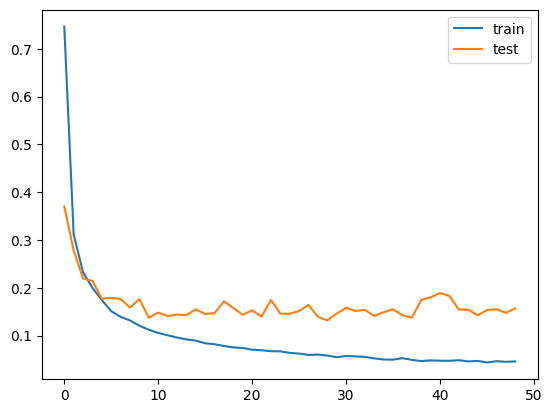

In [19]:
lossi = []
devlossi = []

train_dataset = TensorDataset(X_train, y_train)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in tqdm(range(50)):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        out, logits = ironman.forward(X_batch)
        
        optimizer.zero_grad()
        loss = criterion(logits, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    lossi.append(epoch_loss / len(train_loader))  # append avg loss per epoch

    with torch.no_grad():
        devout, devlogits = ironman.forward(X_test)
        devloss  = criterion(devlogits, y_test)
        devlossi.append(devloss.item())
    
    if epoch % 2 == 0:
        plt.close()
        plt.plot(lossi, label='train')
        plt.plot(devlossi, label='test')
        plt.legend()
        plt.savefig("loss.png")

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.96      0.97      0.96      1032
           3       0.92      0.97      0.95      1010
           4       0.98      0.95      0.96       982
           5       0.96      0.91      0.93       892
           6       0.98      0.94      0.96       958
           7       0.97      0.96      0.96      1028
           8       0.95      0.97      0.96       974
           9       0.95      0.96      0.96      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



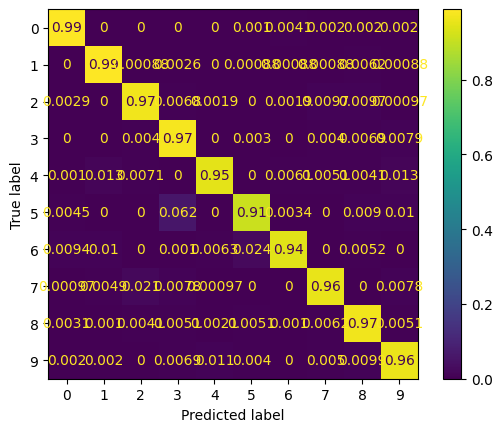

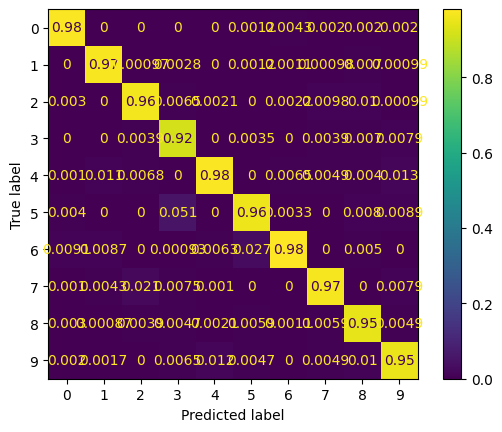

In [20]:
with torch.no_grad():
    y_pred, logits = ironman.forward(X_test)
    y_pred = y_pred.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='true');

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='pred');


print(classification_report(y_true=y_true, y_pred=y_pred));


### 🔄 Now, Let's Do a NN with Convolution

---

##### 🖼️ Reshaping the Data for Convolution

We originally had the data as a 784-long array of the pixel values, but now we want it back to be 28 by 28 so we can run convolution on it. So let's unsqueeze it and get started!


In [31]:
X_train = X_train.view(-1,28,28).unsqueeze(1)

X_test = X_test.view(-1,28,28).unsqueeze(1)
X_test.shape

torch.Size([10000, 1, 28, 28])

### 🏗️ Model Architecture Idea

Alright, here's the plan for our model architecture. We want to keep it lightweight but still achieve better performance than the 96% accuracy from the MLP.

- **Conv Layer**: One convolutional layer with a 3x3 kernel and 8 features
- **Pooling Layer**: One max pooling layer
- **Fully Connected Layers**: Three fully connected layers

Let's build this model and see how it performs! 🚀


In [ ]:
class CORKSCREW(nn.Module):
    def __init__(self, dropout_rate=.5):
        super(CORKSCREW, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc0 = nn.Linear(8 * 14 * 14, 512)
        self.dropout0 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512,64)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64,10)


        self.relu = nn.ReLU()
        self.out = nn.Softmax()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        
        x = x.view(-1, 8 * 14 * 14)  #flatten
        
        x = self.dropout0(self.relu(self.fc0(x)))
        x =  self.dropout1(self.relu(self.fc1(x)))
        logits = self.relu(self.fc2(x))
        out = self.out(logits)
        
        return out, logits

corkscrew = CORKSCREW()
optimizer = torch.optim.AdamW(params=corkscrew.parameters(), lr=0.0003, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

In [37]:
X_train.shape

torch.Size([60000, 1, 28, 28])

  0%|          | 0/10 [00:00<?, ?it/s]/home/kuba/VirEnvs/base/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 10/10 [11:56<00:00, 71.62s/it]


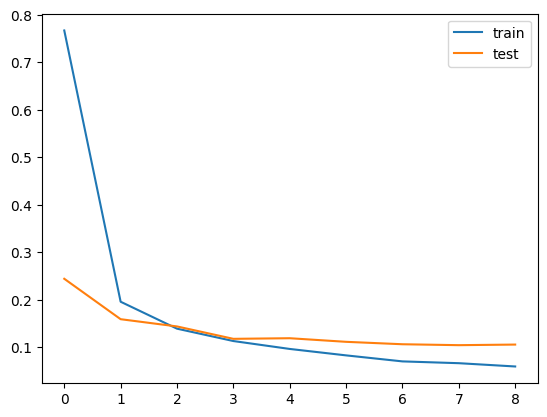

In [41]:

lossi = []
devlossi = []

train_dataset = TensorDataset(X_train, y_train)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


for epoch in tqdm(range(10)):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        #X_batchd, y_batchd = X_batch.to('cuda:0'), y_batch.to('cuda:0') 
        out, logits = corkscrew.forward(X_batch)
        
        optimizer.zero_grad()
        loss = criterion(logits, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    lossi.append(epoch_loss / len(train_loader))  # append avg loss per epoch

    with torch.no_grad():
        #X_testd, y_testd = X_test.to('cuda:0'), y_test.to('cuda:0')
        devout, devlogits = corkscrew.forward(X_test)
        devloss  = criterion(devlogits, y_test)
        devlossi.append(devloss.item())
    
    if epoch % 2 == 0:
        plt.close()
        plt.plot(lossi, label='train')
        plt.plot(devlossi, label='test')
        plt.legend()
        plt.savefig("loss.png")

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.96      0.99      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.96      0.97      0.96       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



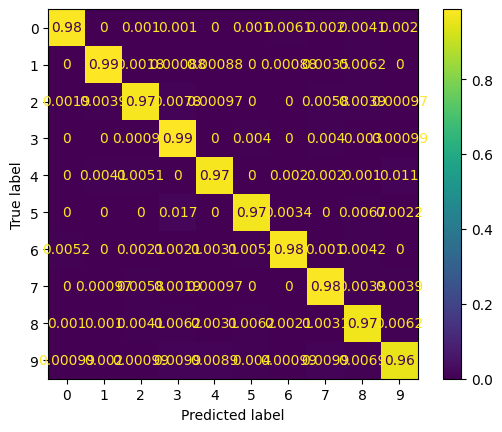

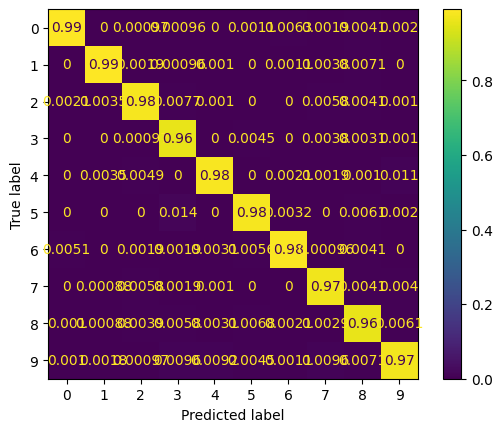

In [42]:
with torch.no_grad():
    y_pred, logits = corkscrew.forward(X_test)
    y_pred = y_pred.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='true');

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='pred');


print(classification_report(y_true=y_true, y_pred=y_pred));

GREAT! //TODO we can do better but we need to tain on a better machine todo